Device: cuda:0
Files already downloaded and verified
Starting Training Loop...
[1/50] Loss_D: 0.2182 Loss_G: 6.0542
[2/50] Loss_D: 0.2443 Loss_G: 4.3950
[3/50] Loss_D: 0.4856 Loss_G: 3.6321
[4/50] Loss_D: 0.5694 Loss_G: 2.8185
[5/50] Loss_D: 1.1179 Loss_G: 1.4079
[6/50] Loss_D: 0.8313 Loss_G: 3.2779
[7/50] Loss_D: 1.7814 Loss_G: 0.2725
[8/50] Loss_D: 0.5790 Loss_G: 1.7370
[9/50] Loss_D: 0.5181 Loss_G: 2.1671
[10/50] Loss_D: 0.4600 Loss_G: 2.1001
[11/50] Loss_D: 0.7426 Loss_G: 1.3655
[12/50] Loss_D: 0.5571 Loss_G: 2.2639
[13/50] Loss_D: 0.7278 Loss_G: 2.1185
[14/50] Loss_D: 0.0594 Loss_G: 3.4739
[15/50] Loss_D: 0.8658 Loss_G: 3.0538
[16/50] Loss_D: 1.1798 Loss_G: 1.1264
[17/50] Loss_D: 0.7052 Loss_G: 1.2518
[18/50] Loss_D: 0.0414 Loss_G: 4.7080
[19/50] Loss_D: 0.2342 Loss_G: 2.0192
[20/50] Loss_D: 0.6565 Loss_G: 1.3078
[21/50] Loss_D: 0.5488 Loss_G: 1.9636
[22/50] Loss_D: 0.2741 Loss_G: 3.5309
[23/50] Loss_D: 0.5858 Loss_G: 2.3603
[24/50] Loss_D: 0.0031 Loss_G: 8.4767
[25/50] Loss_D: 0.

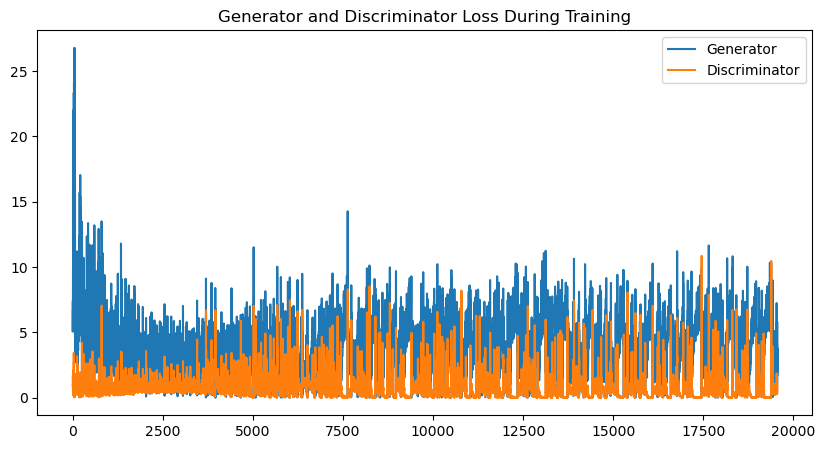

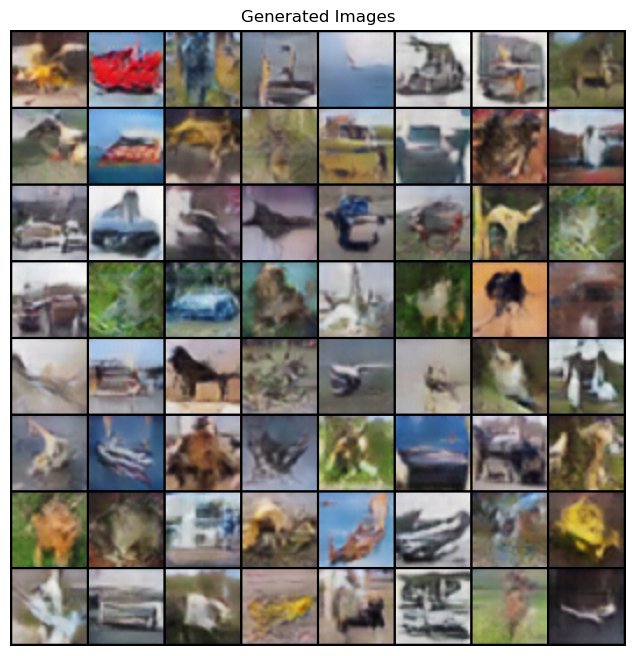

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from torch.nn.functional import adaptive_avg_pool2d
import os

# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)

# Device setup
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Hyperparameters
batch_size = 128
image_size = 64
nz = 100  # Size of latent vector (noise dimension)
nc = 3    # Number of channels in the training images
ngf = 64  # Size of feature maps in the generator
ndf = 64  # Size of feature maps in the discriminator
num_epochs = 50
lr = 2e-4  # Learning rate for both Generator and Discriminator
beta1 = 0.5  # Beta1 hyperparameter for Adam optimizers
real_label = 1.0
fake_label = 0.0

# Data loading and preprocessing
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize to [-1, 1]
])
dataset = datasets.CIFAR10(root="./CIFAR10", download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.main(x)

# Initialize networks
netG = Generator().to(device)
netD = Discriminator().to(device)

# Apply weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

# Loss and optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training
img_list, G_losses, D_losses = [], [], []
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_images = data[0].to(device)
        batch_size = real_images.size(0)
        label_real = torch.full((batch_size,), real_label, device=device)
        output_real = netD(real_images).view(-1)
        loss_real = criterion(output_real, label_real)
        loss_real.backward()

        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label_fake = torch.full((batch_size,), fake_label, device=device)
        output_fake = netD(fake_images.detach()).view(-1)
        loss_fake = criterion(output_fake, label_fake)
        loss_fake.backward()
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label_fake.fill_(real_label)
        output_fake = netD(fake_images).view(-1)
        loss_G = criterion(output_fake, label_fake)
        loss_G.backward()
        optimizerG.step()

        # Record losses
        G_losses.append(loss_G.item())
        D_losses.append(loss_real.item() + loss_fake.item())

    # Save generated images
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    print(f"[{epoch+1}/{num_epochs}] Loss_D: {D_losses[-1]:.4f} Loss_G: {G_losses[-1]:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.legend()
plt.show()

# Visualize generated images
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()
